## Generating Simulated Deformation Events

Simulated Deformation Events are modeled from a finite rectanglar source using the method from: Okada, Surface deformation due to shear and tensile faults in a half-space.

Okada's Paper:  https://www.bosai.go.jp/e/pdf/Okada_1985_BSSA.pdf <br>
Original Basis: https://github.com/matthew-gaddes/SyInterferoPy

### Imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(16,8)

In [33]:
if 'NOTEBOOK_INITIATED_FLAG' not in globals():
    NOTEBOOK_INITIATED_FLAG = True
    %cd ..
%pwd

from src.sarsim import gen_simulated_deformation, gen_sim_noise, Okada

def display_images(unwrapped, wrapped, masked):
    fig, [axs_unwrapped, axs_wrapped, axs_masked] = plt.subplots(1, 3)

    axs_unwrapped.set_title("Unwrapped")
    axs_wrapped.set_title("Wrapped")
    axs_masked.set_title("Mask")

    axs_unwrapped.imshow(unwrapped, cmap='jet')
    axs_wrapped.imshow(wrapped, cmap='jet', vmin=-np.pi, vmax=np.pi)
    axs_masked.imshow(masked, cmap='jet')

#### Input Parameters

In [10]:
tile_size  = 512     # img size is (tile_size, tile_size)
event_type = 'quake' # quake, sill, or dyke

source_x = 20000  # min_x, max_x is 0->45000 at (512, 512)
source_y = 20000  # min_y, max_y is 0->45000 at (512, 512)

kwargs = {
    'strike'      : 180,        # for source_type 'quake'
    'dip'         : 45,         # for source_type 'quake'
    'length'      : 2000,       # for source_type 'quake'
    'rake'        : 90,         # for source_type 'quake'
    'slip'        : 1,          # for source_type 'quake'
    'top_depth'   : 4000,       # for source_type 'quake'
    'bottom_depth': 8000,       # for source_type 'quake'
    'width'       : 2000,       # for source_type 'sill' and 'dyke'
    'depth'       : 4000,       # for source_type 'sill' and 'dyke'
    'opening'     : 0.5,        # for source_type 'sill' and 'dyke',
    'source_x'    : source_x,
    'source_y'    : source_y
}

#### Using gen_simulated_deformation with kwargs

The function gen_simulated_deformation does the preceeding process automatically. Including our kwargs will create the event using the specified options. Please note that all of the dict keys need to be present when using kwargs. It is also important to note that there is randomly generated atmospheric noise, using an fft method; thus, if you want the same image every time, you need to use a seed.

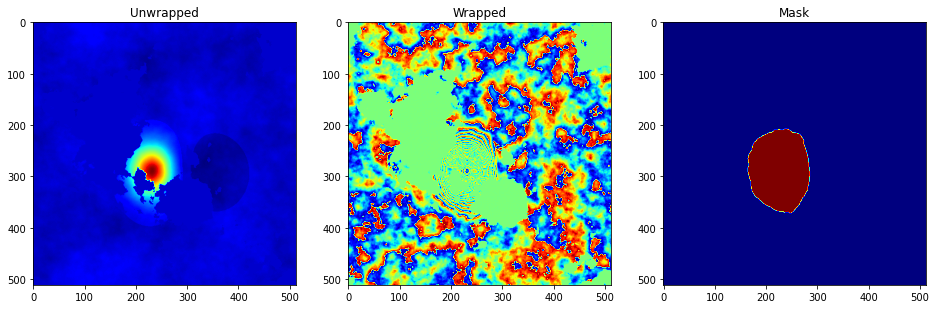

In [25]:
seed       = 0       # 0 seed here means random atmospheric noise every time the function is called.
tile_size  = 512
log        = False
event_type = 'quake'

unwrapped, masked, wrapped, event_is_present = gen_simulated_deformation(
    seed       = seed, 
    tile_size  = tile_size,
    log        = log,
    event_type = event_type,
    **kwargs
)

display_images(unwrapped, wrapped, masked)

#### Using gen_simulated_deformation without kwargs

If no kwargs are provided, the function will randomly generate them within the bounds that have worked best for training purposes. This means that the function will not generate events with all possible valid parameters, at the moment.

__________

quake
__________

Length         (meters)   1418.2451122215357
Top Depth      (meters)   5610.195388651615
Bottom Depth   (meters)   21090.21406408915
Depth          (meters)   2885.4208799715834

Slip           (0  or 1)  1
Dip            (degrees)  75
Rake           (degrees)  -90
Strike         (degrees)  155.89923473816637
Opening:       (meters)   0.5

Max X Position (meters)   46080
Max Y Position (meters)   46080
Src X Position (meters)   31714.0
Src Y Position (meters)   9331.0

Maximum Phase Value:      84.73487224474161

Compute Time   (seconds)  0.13495929800046724
__________



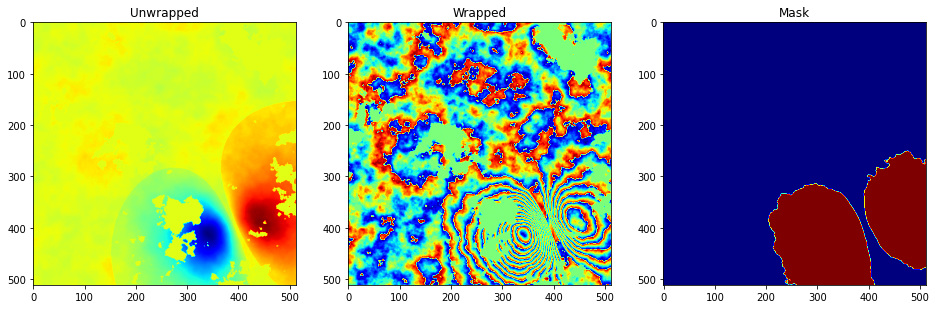

In [26]:
seed       = 0       # 0 seed here means random event paramenters and atmospheric noise
tile_size  = 512
log        = True
event_type = 'quake'

unwrapped, masked, wrapped, event_is_present = gen_simulated_deformation(
    seed       = seed,
    tile_size  = tile_size,
    log        = log,
    event_type = event_type,
)

display_images(unwrapped, wrapped, masked)

#### Generating Simulated Turbulent, Topographic, and Gaussian Noise

Using the gen_sim_noise function, one can generate turbulent atmospheric noise, topographic noise, and gaussian noise tiles. These are currently used as 'negatives' for training purposes. 

Max, Min Noise Values:  23.898441912171148 -17.756211834969214


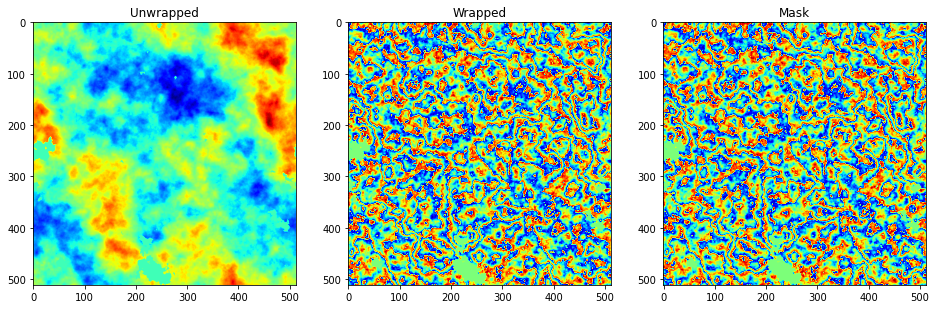

In [27]:
seed              = 0
tile_size         = 512
gaussian_only     = False       # If no atmospheric noise is desired.
atmosphere_scalar = 200 * np.pi # Again, the 'displacement' needs to be scaled.

unwrapped, masked, wrapped, event_is_present = gen_sim_noise(
    seed              = seed,
    tile_size         = tile_size,
    gaussian_only     = False,
    atmosphere_scalar = 200 * np.pi
)

print("Max, Min Noise Values: ", np.max(unwrapped), np.min(unwrapped))

display_images(unwrapped, wrapped, wrapped)

#### Generate Event Manually

If you want to get the actual line-of-sight displacement with no noise or contamination, you can generate a deformation event manually using the Okada class. This requires the basically the same inputs as the gen_simulated_deformation function with kwargs. 

Ultimately, it's purpose is to generate the line-of-sight displacement (self.los_displacement). But it also generates quite of bit of information that you may access:
```python
self.source_type
self.source_x
self.source_y
self.tile_size
self.params
self.x_axis_shape
self.y_axis_shape
self.grid_x
self.grid_y
self.los_vector
self.lames_mu       # μ
self.lames_lambd    # λ
self.nu             # ν (poisson ration)
self.length
self.strike
self.dip            # δ
self.opening
self.slip
self.rake
self.width
self.depth
self.east
self.north
self.okada_x        # ξ
self.okada_y
self.d
self.q
self.eta            # η
self.U1
self.U2
self.U3
self.displacement
self.los_displacement
```

In [28]:
Event = Okada(event_type, (source_x, source_y), tile_size = tile_size, **kwargs)

#### Get Displacement and Amplify

Since the model gives us line-of-sight displacement, the values are generally very low and won't even get close to wrapping around pi. Because of this, we need to scale the values for them to be useful for our purposes.

In [31]:
scalar           = 1000 * np.pi
los_displacement = Event.los_displacement
phase            = scalar * los_displacement
wrapped_phase    = np.angle(np.exp(1j * (phase)))

Max, Min Displacement:  0.05249679703582018 , -0.0037120933592790133
Max, Min Phase:         164.92355190472708 ,  -11.661885226950403


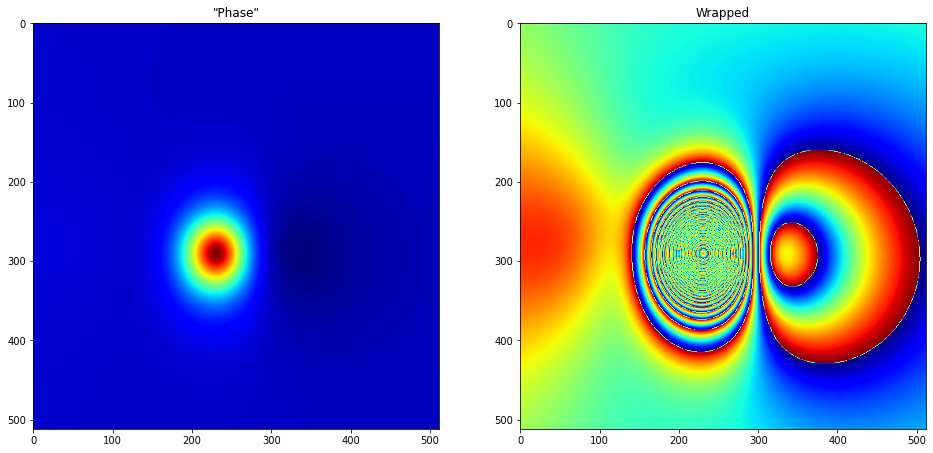

In [32]:
print('Max, Min Displacement: ', np.max(los_displacement), ',', np.min(los_displacement))
print('Max, Min Phase:        ', np.max(phase), ', ', np.min(phase))

fig, [axs_phase, axs_wrapped] = plt.subplots(1, 2)
axs_wrapped.set_title("Wrapped")
axs_wrapped.imshow(wrapped_phase, cmap='jet')
axs_phase.set_title("\"Phase\"")
axs_phase.imshow(phase, cmap='jet')